<a href="https://colab.research.google.com/github/nek96/t-SNE_Dimensionality-reduction-method-applying-on-Glove.50d.text-2000-words-vector-/blob/main/PCA%2Ct_SNE%2CUMAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PCA Mean Squared Error: 0.0096
Explained Variance Ratio: 0.1593
Continuity: 0.8467491654021244
Trustworthiness: 0.6929522677457427


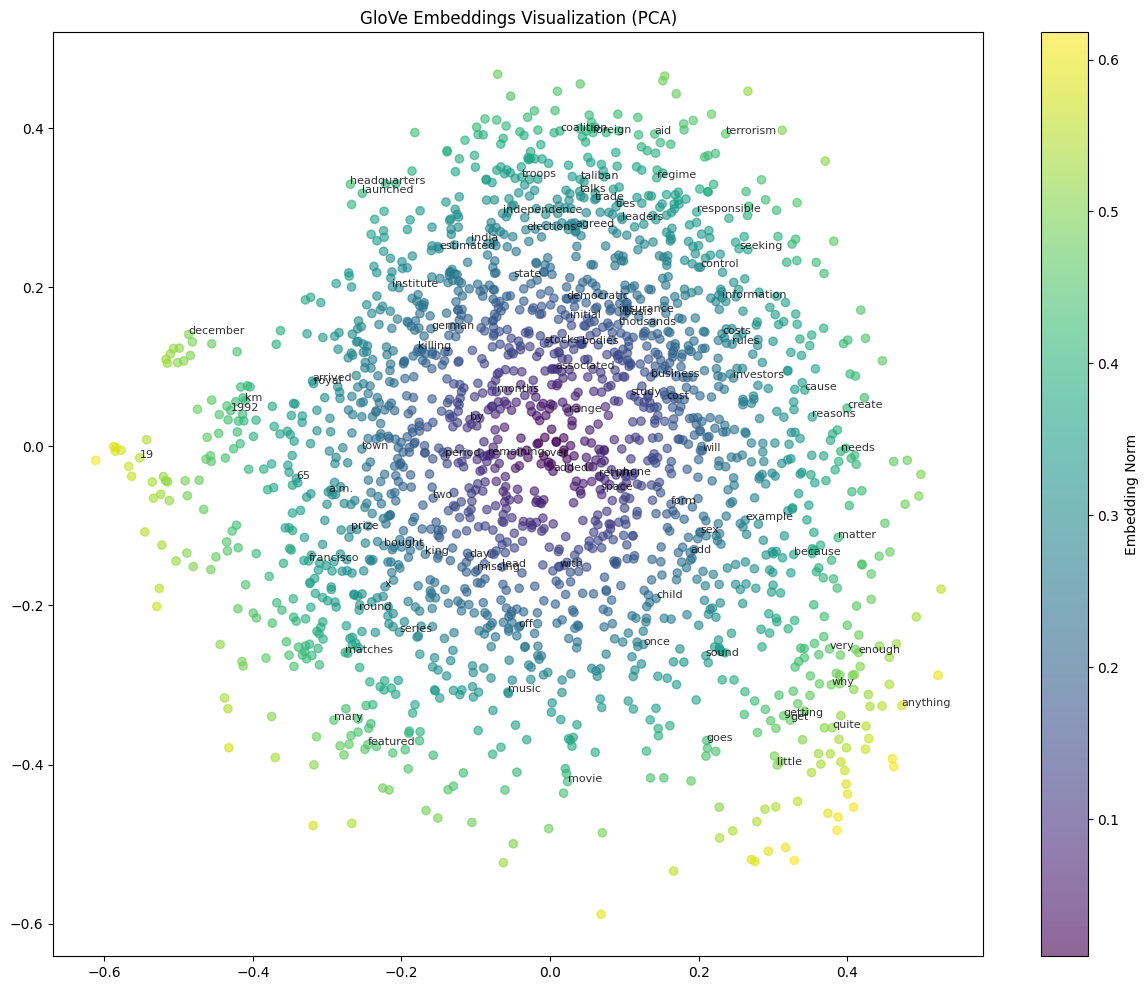

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ======================
# GloVe Data Loader
# ======================
class GloVeLoader:
    def __init__(self, file_path, max_words=2000):
        self.file_path = file_path
        self.max_words = max_words

    def load(self):
        """Load and normalize GloVe embeddings"""
        words, vectors = [], []
        with open(self.file_path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if idx >= self.max_words:
                    break
                parts = line.strip().split()
                words.append(parts[0])
                vectors.append(np.array(parts[1:], dtype=np.float32))

        vectors = np.array(vectors)
        vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
        return words, vectors

# ======================
# PCA Method
# ======================
def apply_pca(vectors, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(vectors)
    reconstructed_vectors = pca.inverse_transform(reduced_vectors)

    mse = np.mean((vectors - reconstructed_vectors) ** 2)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    return reduced_vectors, mse, explained_variance

# ======================
# Visualization Function
# ======================
def visualize_glove_embeddings(words, embeddings):
    plt.figure(figsize=(15, 12))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6, c=np.linalg.norm(embeddings, axis=1))

    # Annotate sample words
    indices = np.random.choice(len(words), 100, replace=False)
    for i in indices:
        plt.annotate(words[i], (embeddings[i, 0], embeddings[i, 1]), fontsize=8, alpha=0.8)

    plt.colorbar(label='Embedding Norm')
    plt.title("GloVe Embeddings Visualization (PCA)")
    plt.show()

# ======================
# Corrected Continuity and Trustworthiness Functions
# ======================
def continuity_and_trustworthiness(X, X_embedded, n_neighbors=15):
    """
    Calculate continuity and trustworthiness metrics for dimensionality reduction.
    """
    n = X.shape[0]

    # Compute pairwise distances
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_embedded)

    # Get full rankings for high-D and low-D spaces
    rank_high = np.argsort(D_high, axis=1)
    rank_low = np.argsort(D_low, axis=1)

    # Initialize sums for continuity and trustworthiness
    continuity_sum = 0
    trustworthiness_sum = 0

    for i in range(n):
        # Get the top-k neighbors in high-D and low-D
        high_neighbors = set(rank_high[i, 1:n_neighbors+1])
        low_neighbors = set(rank_low[i, 1:n_neighbors+1])

        # Missing neighbors: in high-D but not in low-D
        missing_neighbors = high_neighbors - low_neighbors
        # Extra neighbors: in low-D but not in high-D
        extra_neighbors = low_neighbors - high_neighbors

        # Continuity penalty: for missing neighbors, use their rank in low-D
        for m in missing_neighbors:
            rank_m = np.where(rank_low[i] == m)[0][0]  # Rank in low-D
            continuity_sum += max(0, rank_m - n_neighbors)

        # Trustworthiness penalty: for extra neighbors, use their rank in high-D
        for e in extra_neighbors:
            rank_e = np.where(rank_high[i] == e)[0][0]  # Rank in high-D
            trustworthiness_sum += max(0, rank_e - n_neighbors)

    # Normalization factors
    normalization = 2 / (n * n_neighbors * (2 * n - 3 * n_neighbors - 1))

    # Calculate final metrics
    continuity = 1 - normalization * continuity_sum
    trustworthiness = 1 - normalization * trustworthiness_sum

    return continuity, trustworthiness

# ======================
# Execution
# ======================
if __name__ == "__main__":
    # Configuration
    GLOVE_PATH = 'glove.6B.50d.txt'
    MAX_WORDS = 2000

    # Load data
    loader = GloVeLoader(GLOVE_PATH, max_words=MAX_WORDS)
    words, vectors = loader.load()

    # Apply PCA
    reduced_vectors, mse, explained_variance = apply_pca(vectors, n_components=2)

    # Output MSE and explained variance
    print(f"PCA Mean Squared Error: {mse:.4f}")
    print(f"Explained Variance Ratio: {explained_variance:.4f}")

    # Calculate and print continuity and trustworthiness
    continuity, trustworthiness = continuity_and_trustworthiness(vectors, reduced_vectors)
    print("Continuity:", continuity)
    print("Trustworthiness:", trustworthiness)

    # Visualize results
    visualize_glove_embeddings(words, reduced_vectors)

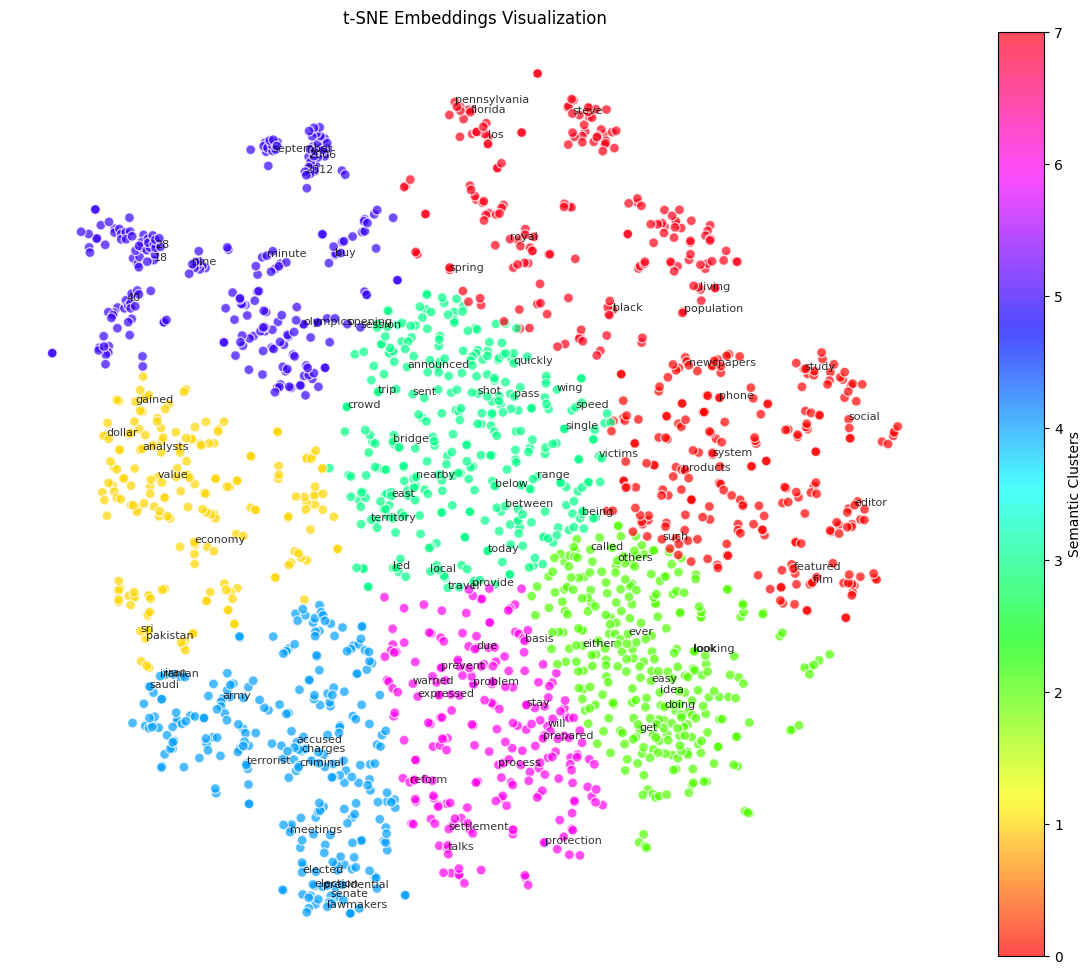


Metrics for t-SNE Embeddings:
Mean Squared Error (MSE): 0.009580
Trustworthiness: 0.9494
Continuity: 0.8941


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics import pairwise_distances, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ======================
# GloVe Data Loader
# ======================
class GloVeLoader:
    def __init__(self, file_path, max_words=2000):
        self.file_path = file_path
        self.max_words = max_words

    def load(self):
        """Load and normalize GloVe embeddings"""
        words, vectors = [], []
        with open(self.file_path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if idx >= self.max_words:
                    break
                parts = line.strip().split()
                words.append(parts[0])
                vectors.append(np.array(parts[1:], dtype=np.float32))

        vectors = np.array(vectors)
        vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)  # Normalize embeddings
        return words, vectors

# ======================
# t-SNE Embedding and Visualization
# ======================
def apply_tsne(vectors, n_components=2, perplexity=30, learning_rate=200):
    """Apply t-SNE to reduce dimensionality"""
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    return reduced_vectors

def visualize_tsne_embeddings(words, embeddings, n_clusters=8):
    """Visualize t-SNE embeddings with clustering"""
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(15, 12))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='hsv', alpha=0.7, edgecolors='w', s=50)

    # Annotate a subset of words
    indices = np.random.choice(len(words), 100, replace=False)  # Annotate 100 random words
    for i in indices:
        plt.annotate(words[i], (embeddings[i, 0], embeddings[i, 1]), fontsize=8, alpha=0.8)

    plt.colorbar(scatter, label='Semantic Clusters')
    plt.title("t-SNE Embeddings Visualization")
    plt.axis('off')
    plt.show()

# ======================
# Metrics Calculation
# ======================
def calculate_mse(original, reconstructed):
    """Calculate Mean Squared Error (MSE)"""
    return mean_squared_error(original, reconstructed)

def calculate_trustworthiness(high_dim, low_dim, n_neighbors=10):
    """Calculate Trustworthiness of the embeddings"""
    return trustworthiness(high_dim, low_dim, n_neighbors=n_neighbors)

def calculate_continuity(high_dim, low_dim, n_neighbors=10):
    """Calculate Continuity of the embeddings"""
    return trustworthiness(low_dim, high_dim, n_neighbors=n_neighbors)

# ======================
# Main Execution
# ======================
if __name__ == "__main__":
    # Configuration
    GLOVE_PATH = 'glove.6B.50d.txt'  # Path to GloVe file
    MAX_WORDS = 2000  # Number of words to load
    PERPLEXITY = 30  # t-SNE perplexity
    LEARNING_RATE = 200  # t-SNE learning rate

    # Load data
    loader = GloVeLoader(GLOVE_PATH, max_words=MAX_WORDS)
    words, vectors = loader.load()

    # Apply t-SNE
    tsne_embeddings = apply_tsne(vectors, perplexity=PERPLEXITY, learning_rate=LEARNING_RATE)

    # Visualize t-SNE embeddings
    visualize_tsne_embeddings(words, tsne_embeddings)

    # Calculate metrics
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(vectors)
    pca_reconstructed = pca.inverse_transform(pca_embeddings)  # Reconstruct to original dimensions

    mse = calculate_mse(vectors, pca_reconstructed)  # MSE compared to PCA reconstruction
    trustworthiness_score = calculate_trustworthiness(vectors, tsne_embeddings)
    continuity_score = calculate_continuity(vectors, tsne_embeddings)

    # Print metrics
    print("\nMetrics for t-SNE Embeddings:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Trustworthiness: {trustworthiness_score:.4f}")
    print(f"Continuity: {continuity_score:.4f}")


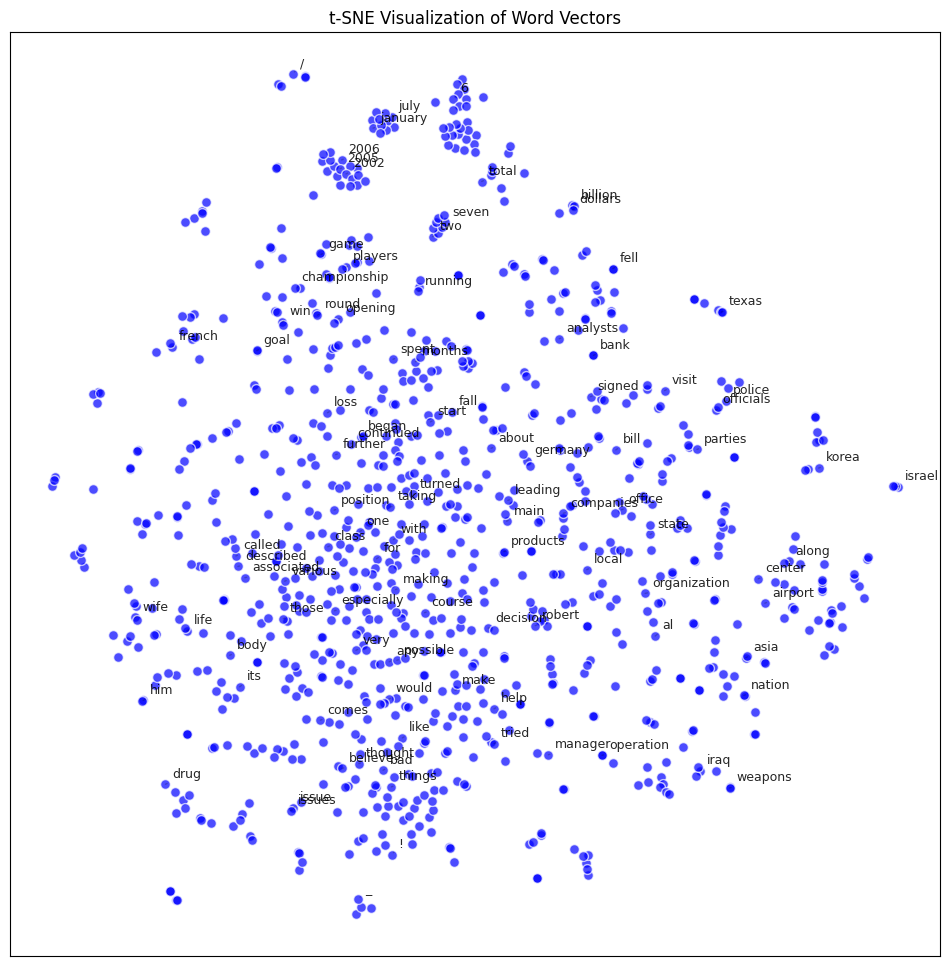

Trustworthiness:  0.8285082906857728
Continuity:  0.3476666666666667


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, trustworthiness
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Load GloVe embeddings with words
def load_glove(file_path, max_words=1000):
    embeddings = []
    words = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_words:
                break
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings.append(vector)
            words.append(word)
    return np.array(embeddings), words

glove_path = 'glove.6B.100d.txt'  # Update path to your GloVe file
embeddings, words = load_glove(glove_path, max_words=1000)

# Standardize embeddings
scaler = StandardScaler()
data_scaled = scaler.fit_transform(embeddings)

# Apply t-SNE for dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne_model.fit_transform(data_scaled)

# Plotting the t-SNE embeddings
plt.figure(figsize=(12, 12))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c='blue', alpha=0.7, edgecolors='w', s=50)

# Annotating some points
placed_indices = set()
for idx in np.random.permutation(len(words)):
    if len(placed_indices) > 100:
        break
    conflict = any(np.linalg.norm(tsne_embeddings[idx] - tsne_embeddings[pid]) < 0.05 for pid in placed_indices)
    if not conflict:
        plt.annotate(words[idx], tsne_embeddings[idx], xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.85,
                     arrowprops=dict(arrowstyle='-', alpha=0.2))
        placed_indices.add(idx)

plt.title("t-SNE Visualization of Word Vectors")
plt.xticks([])
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.show()

# Calculate MSE (if applicable), trustworthiness, and continuity
def calculate_metrics(X_high, X_low, n_neighbors=15):
    metrics = {}
    metrics['Trustworthiness'] = trustworthiness(X_high, X_low, n_neighbors=n_neighbors)

    # Continuity
    knn_high = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X_high)
    knn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low)
    continuity_sum = 0
    for i in range(len(X_high)):
        high_neighbors = knn_high.kneighbors([X_high[i]], return_distance=False)[0][1:]
        low_neighbors = knn_low.kneighbors([X_low[i]], return_distance=False)[0]
        continuity_sum += len(np.intersect1d(high_neighbors, low_neighbors))
    metrics['Continuity'] = continuity_sum / (len(X_high) * n_neighbors)

    return metrics

# Calculate metrics
metrics = calculate_metrics(data_scaled, tsne_embeddings)
print("Trustworthiness: ", metrics['Trustworthiness'])
print("Continuity: ", metrics['Continuity'])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


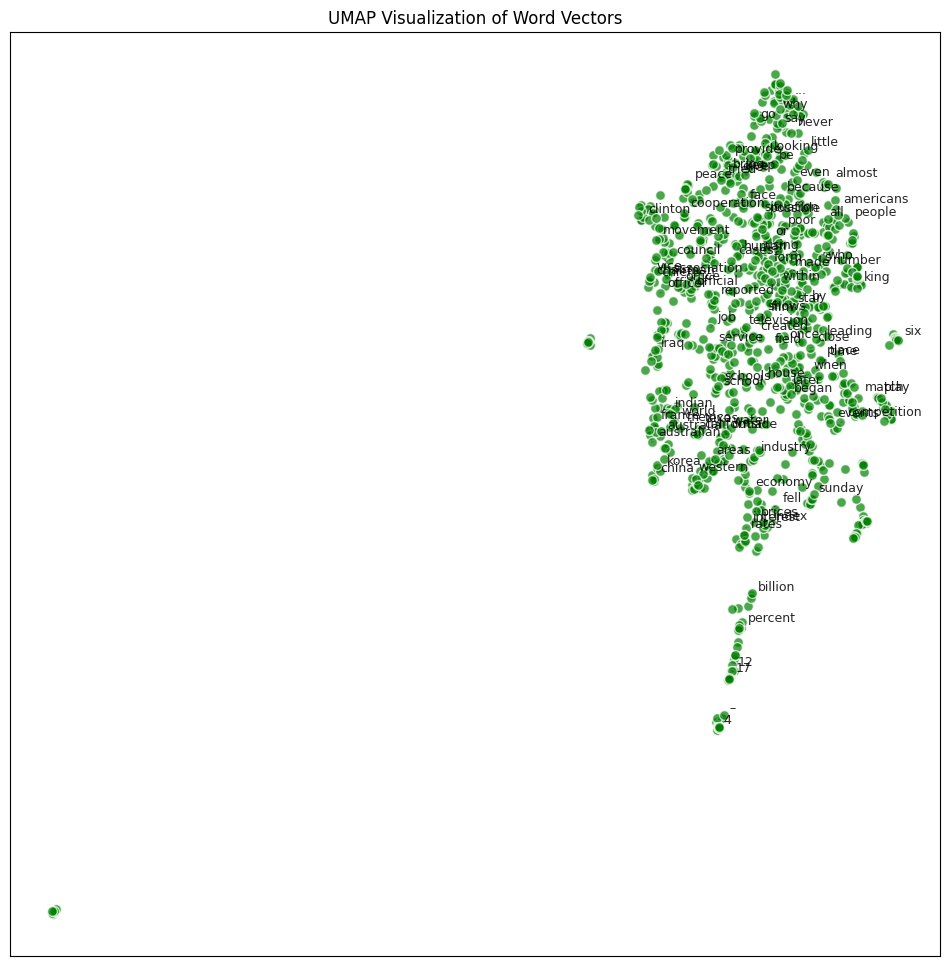

UMAP Metrics
Trustworthiness:  0.8316751961787785
Continuity:  0.3346


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import trustworthiness
import umap
from sklearn.neighbors import NearestNeighbors

# Load GloVe embeddings with words
def load_glove(file_path, max_words=1000):
    embeddings = []
    words = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_words:
                break
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings.append(vector)
            words.append(word)
    return np.array(embeddings), words

glove_path = 'glove.6B.100d.txt'  # Update path to your GloVe file
embeddings, words = load_glove(glove_path, max_words=1000)

# Standardize embeddings
scaler = StandardScaler()
data_scaled = scaler.fit_transform(embeddings)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(data_scaled)

# Plotting the UMAP embeddings
plt.figure(figsize=(12, 12))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c='green', alpha=0.7, edgecolors='w', s=50)

# Annotating some points
placed_indices = set()
for idx in np.random.permutation(len(words)):
    if len(placed_indices) > 100:
        break
    conflict = any(np.linalg.norm(umap_embeddings[idx] - umap_embeddings[pid]) < 0.05 for pid in placed_indices)
    if not conflict:
        plt.annotate(words[idx], umap_embeddings[idx], xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.85,
                     arrowprops=dict(arrowstyle='-', alpha=0.2))
        placed_indices.add(idx)

plt.title("UMAP Visualization of Word Vectors")
plt.xticks([])
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.show()

# Calculate metrics: trustworthiness and continuity
def calculate_metrics(X_high, X_low, n_neighbors=15):
    metrics = {}
    metrics['Trustworthiness'] = trustworthiness(X_high, X_low, n_neighbors=n_neighbors)

    # Continuity
    knn_high = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X_high)
    knn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low)
    continuity_sum = 0
    for i in range(len(X_high)):
        high_neighbors = knn_high.kneighbors([X_high[i]], return_distance=False)[0][1:]
        low_neighbors = knn_low.kneighbors([X_low[i]], return_distance=False)[0]
        continuity_sum += len(np.intersect1d(high_neighbors, low_neighbors))
    metrics['Continuity'] = continuity_sum / (len(X_high) * n_neighbors)

    return metrics

# Calculate metrics for UMAP
umap_metrics = calculate_metrics(data_scaled, umap_embeddings)
print("UMAP Metrics")
print("Trustworthiness: ", umap_metrics['Trustworthiness'])
print("Continuity: ", umap_metrics['Continuity'])
